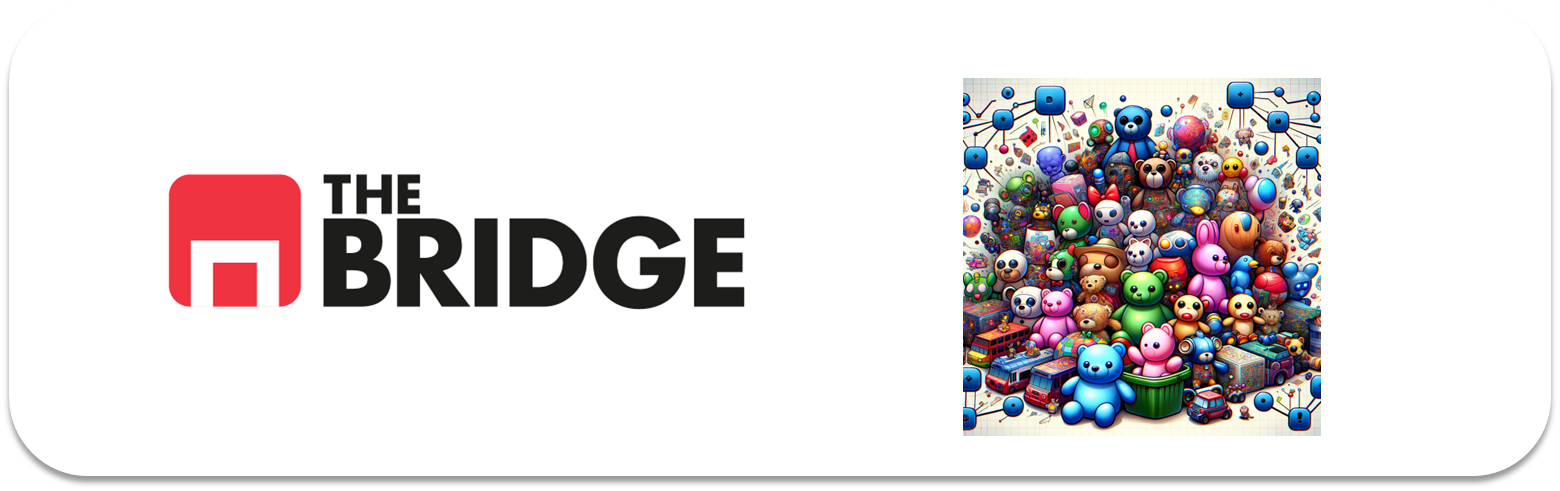

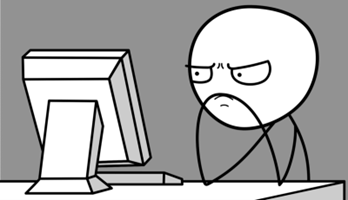

## PRACTICA OBLIGATORIA: K-MEANS

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado sobre imágenes para practicar con el algoritmo k-means. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, roc_auc_score

## **#1**

Vamos a trabajar con un dataset también entre los "clásicos" (aunque a veces menos conocido) que es el de rostros Olivetti. Este dataset contiene 400 imágenes en escala de grises de 64 × 64 píxeles de rostros.   


Como en otros datasets de imágenes, estás están "aplanadas" de forma que cada pixel es una feature y por cada imagen hay $64\times 64 = 4096$ features.  

Se fotografiaron 40 personas diferentes (10 veces cada una) y esas fotografías se recogen en el dataset.  

La tarea habitual es entrenar un modelo que pueda predecir qué persona está representada en cada imagen, pero nosotros lo vamos a hacer de forma no supervisada. 



### #1.1


Carga el conjunto de datos usando la función `sklearn.datasets.fetch_olivetti_faces()`. Recuerda que se carga un "diccionario". Muestra su descripción acudiendo a la clave "DESCR".

In [3]:
from sklearn.datasets import fetch_olivetti_faces

# Cargar el conjunto de datos
faces = fetch_olivetti_faces()

# Mostrar la descripción del conjunto de datos
print(faces['DESCR'])


.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position
    (with tolerance for some side movement).

**Data Set Characteristics:**

=================   =====================
Classes              

### #1.2 

Aunque no lo vas a usar hasta el final de la práctica, muestra el target. Luego cargalo todo en un mismo dataframe (tendrás que añadir el target) y obtén otro dataset con todas las imagenes reordenadas aleatoriamente (emplea por ejemplo el método `sample` del dataframe o el método que tú quieras)

In [4]:
# Cargar el conjunto de datos
faces = fetch_olivetti_faces()

# Mostrar la descripción del conjunto de datos
print(faces['DESCR'])

# Mostrar el target
print("Target:", faces['target'])

# Crear un DataFrame con las imágenes y el target
data = pd.DataFrame(faces['data'])
data['target'] = faces['target']

# Reordenar aleatoriamente el dataset
shuffled_data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Mostrar las primeras filas del dataset reorganizado
print(shuffled_data.head())


.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position
    (with tolerance for some side movement).

**Data Set Characteristics:**

=================   =====================
Classes              

### #1.3

Vamos a dividir en train y test, pero OJO RECUERDA QUE EN LOS PROBLEMAS NO SUPERVISADOS NO HAY SPLIT (porque no hay target), aquí lo hacemos para poder comparar posteriormente el clustering con la clasificación (ya que es uan práctica formativa).

Por tanto, divídelo en un conjunto de entrenamiento, un conjunto de validación y un conjunto de pruebas (80-10-10). Dado que el conjunto de datos es bastante pequeño, emplea un muestreo estratificado para asegurarse de que haya el mismo número de imágenes por persona en cada conjunto (estratificando por la columna que contenga el target)

NOTA: No hemos hecho hasta ahora la separación en tres sets, investiga por tu cuenta o bien haz primero un split 90-10 y luego otro split 89-11 sobre el de 80 (para que de los números aproximados), por ejemplo.

In [5]:
# Dividir en conjunto de entrenamiento (80%) y el restante (20%) con muestreo estratificado
train_data, temp_data = train_test_split(shuffled_data, test_size=0.2, stratify=shuffled_data['target'], random_state=42)

# Dividir el 20% restante en validación (10%) y prueba (10%) con muestreo estratificado
val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=temp_data['target'], random_state=42)

# Mostrar el tamaño de cada conjunto
print(f"Tamaño del conjunto de entrenamiento: {len(train_data)}")
print(f"Tamaño del conjunto de validación: {len(val_data)}")
print(f"Tamaño del conjunto de prueba: {len(test_data)}")


Tamaño del conjunto de entrenamiento: 320
Tamaño del conjunto de validación: 40
Tamaño del conjunto de prueba: 40


### #1.4

Crea los pares X,y para train, validation y test.

In [6]:
# Crear los pares X, y para train, validation y test
X_train, y_train = train_data.drop(columns=['target']), train_data['target']
X_val, y_val = val_data.drop(columns=['target']), val_data['target']
X_test, y_test = test_data.drop(columns=['target']), test_data['target']

# Mostrar el tamaño de cada conjunto
print(f"Tamaño del conjunto de entrenamiento: {len(X_train)}")
print(f"Tamaño del conjunto de validación: {len(X_val)}")
print(f"Tamaño del conjunto de prueba: {len(X_test)}")


Tamaño del conjunto de entrenamiento: 320
Tamaño del conjunto de validación: 40
Tamaño del conjunto de prueba: 40


Utiliza la siguiente función para visualizar alguna de las caras (observa que tienes que dar la X y la y, usa iloc en ambos datasets)

In [15]:
def plot_faces(faces, labels, n_cols=5):
    faces = faces.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

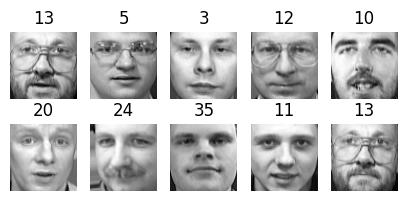

In [7]:
# Función para visualizar algunas caras
def plot_faces(faces, labels, n_cols=5):
    faces = faces.values.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

# Visualizar algunas caras de entrenamiento
plot_faces(X_train.iloc[:10], y_train.iloc[:10])


### #1.5

Para acelerar las cosas, reduciremos la dimensionalidad de los datos utilizando PCA (técnica que veremos en el siguiente sprint). Modifica la siguiente celda de forma que las X se correspondan con las que has utilizado en el ejercicio anterior.

Tamaño del conjunto de entrenamiento: 320
Tamaño del conjunto de validación: 40
Tamaño del conjunto de prueba: 40
Número de componentes principales seleccionados: 221


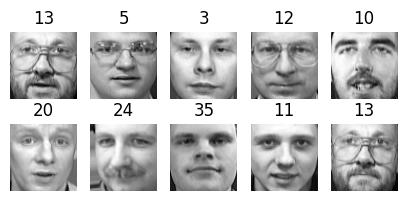

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt

# Crear los pares X, y para train, validation y test
X_train, y_train = train_data.drop(columns=['target']), train_data['target']
X_valid, y_valid = val_data.drop(columns=['target']), val_data['target']  # Corregir nombre a X_valid
X_test, y_test = test_data.drop(columns=['target']), test_data['target']

# Mostrar el tamaño de cada conjunto
print(f"Tamaño del conjunto de entrenamiento: {len(X_train)}")
print(f"Tamaño del conjunto de validación: {len(X_valid)}")
print(f"Tamaño del conjunto de prueba: {len(X_test)}")

# Aplicar PCA para reducir la dimensionalidad con 99% de varianza explicada
pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

# Mostrar el número de componentes principales seleccionados
total_components = pca.n_components_
print(f"Número de componentes principales seleccionados: {total_components}")

# Función para visualizar algunas caras
def plot_faces(faces, labels, n_cols=5):
    faces = faces.values.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

# Visualizar algunas caras de entrenamiento
plot_faces(X_train.iloc[:10], y_train.iloc[:10])


In [11]:
from sklearn.decomposition import PCA

pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

pca.n_components_

221

### 1.6

Aquí viene la parte del león. A continuación, agrupa las imágenes utilizando K-Means sobre el dataset de train reducido en el ejercicio anterior. Emplea el método del máximo de score de silueta para obtener el mejor k, probando con K de 5 en 5 hasta 150. ¿Cuál es el k que proporciona el mejor score de silueta? NOTA: Emplea todas las features (no hace falta seleccionar, y ya están escaladas entre 0 y 1)

Tamaño del conjunto de entrenamiento: 320
Tamaño del conjunto de validación: 40
Tamaño del conjunto de prueba: 40
Número de componentes principales seleccionados: 221
Para k=5, el score de silueta es: 0.10690534114837646
Para k=10, el score de silueta es: 0.0917917937040329
Para k=15, el score de silueta es: 0.0968705415725708
Para k=20, el score de silueta es: 0.10888216644525528
Para k=25, el score de silueta es: 0.11888276040554047
Para k=30, el score de silueta es: 0.130244642496109
Para k=35, el score de silueta es: 0.1406320482492447
Para k=40, el score de silueta es: 0.1507929116487503
Para k=45, el score de silueta es: 0.1597384512424469
Para k=50, el score de silueta es: 0.17102989554405212
Para k=55, el score de silueta es: 0.16867895424365997
Para k=60, el score de silueta es: 0.1802489310503006
Para k=65, el score de silueta es: 0.1804104596376419
Para k=70, el score de silueta es: 0.18818716704845428
Para k=75, el score de silueta es: 0.19661825895309448
Para k=80, el scor

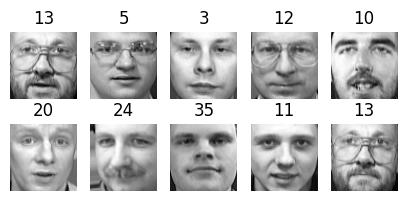

In [13]:

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Crear los pares X, y para train, validation y test
X_train, y_train = train_data.drop(columns=['target']), train_data['target']
X_valid, y_valid = val_data.drop(columns=['target']), val_data['target']  # Corregir nombre a X_valid
X_test, y_test = test_data.drop(columns=['target']), test_data['target']

# Mostrar el tamaño de cada conjunto
print(f"Tamaño del conjunto de entrenamiento: {len(X_train)}")
print(f"Tamaño del conjunto de validación: {len(X_valid)}")
print(f"Tamaño del conjunto de prueba: {len(X_test)}")

# Aplicar PCA para reducir la dimensionalidad con 99% de varianza explicada
pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

# Mostrar el número de componentes principales seleccionados
total_components = pca.n_components_
print(f"Número de componentes principales seleccionados: {total_components}")

# Encontrar el mejor número de clusters usando la métrica de silueta
best_k = 0
best_score = -1
for k in range(5, 151, 5):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_train_pca)
    silhouette_avg = silhouette_score(X_train_pca, cluster_labels)
    print(f"Para k={k}, el score de silueta es: {silhouette_avg}")
    
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_k = k

print(f"El mejor k es {best_k} con un score de silueta de {best_score}")

# Función para visualizar algunas caras
def plot_faces(faces, labels, n_cols=5):
    faces = faces.values.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

# Visualizar algunas caras de entrenamiento
plot_faces(X_train.iloc[:10], y_train.iloc[:10])



### #1.7

Repite el ejercio anterior empleando ahora el método del codo de Inercia. ¿Sale algo más concluyente o que refuerce el anterior resultado?

Tamaño del conjunto de entrenamiento: 320
Tamaño del conjunto de validación: 40
Tamaño del conjunto de prueba: 40
Número de componentes principales seleccionados: 221
Para k=5, el score de silueta es: 0.10690534114837646
Para k=10, el score de silueta es: 0.0917917937040329
Para k=15, el score de silueta es: 0.0968705415725708
Para k=20, el score de silueta es: 0.10888216644525528
Para k=25, el score de silueta es: 0.11888276040554047
Para k=30, el score de silueta es: 0.130244642496109
Para k=35, el score de silueta es: 0.1406320482492447
Para k=40, el score de silueta es: 0.1507929116487503
Para k=45, el score de silueta es: 0.1597384512424469
Para k=50, el score de silueta es: 0.17102989554405212
Para k=55, el score de silueta es: 0.16867895424365997
Para k=60, el score de silueta es: 0.1802489310503006
Para k=65, el score de silueta es: 0.1804104596376419
Para k=70, el score de silueta es: 0.18818716704845428
Para k=75, el score de silueta es: 0.19661825895309448
Para k=80, el scor

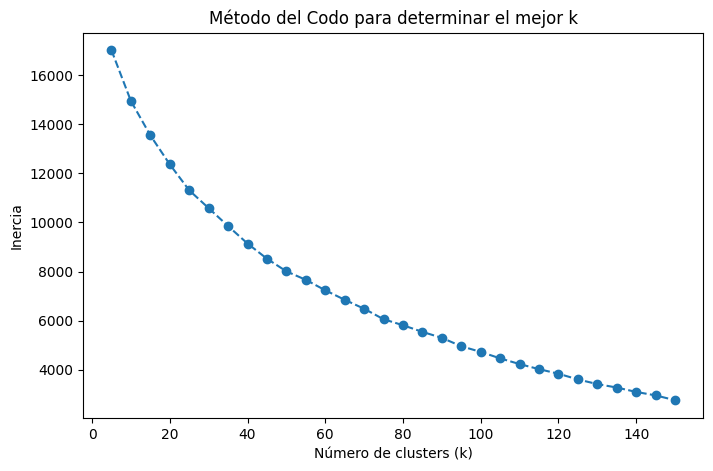

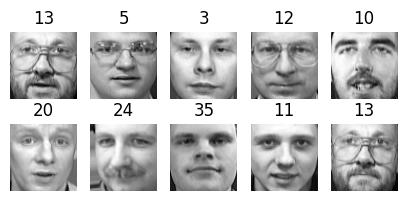

In [14]:


# Crear los pares X, y para train, validation y test
X_train, y_train = train_data.drop(columns=['target']), train_data['target']
X_valid, y_valid = val_data.drop(columns=['target']), val_data['target']  # Corregir nombre a X_valid
X_test, y_test = test_data.drop(columns=['target']), test_data['target']

# Mostrar el tamaño de cada conjunto
print(f"Tamaño del conjunto de entrenamiento: {len(X_train)}")
print(f"Tamaño del conjunto de validación: {len(X_valid)}")
print(f"Tamaño del conjunto de prueba: {len(X_test)}")

# Aplicar PCA para reducir la dimensionalidad con 99% de varianza explicada
pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

# Mostrar el número de componentes principales seleccionados
total_components = pca.n_components_
print(f"Número de componentes principales seleccionados: {total_components}")

# Encontrar el mejor número de clusters usando la métrica de silueta
best_k = 0
best_score = -1
for k in range(5, 151, 5):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_train_pca)
    silhouette_avg = silhouette_score(X_train_pca, cluster_labels)
    print(f"Para k={k}, el score de silueta es: {silhouette_avg}")
    
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_k = k

print(f"El mejor k es {best_k} con un score de silueta de {best_score}")

# Método del codo para determinar el mejor K basándose en la inercia
inertia = []
k_values = list(range(5, 151, 5))
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train_pca)
    inertia.append(kmeans.inertia_)

# Graficar la inercia para el método del codo
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='--')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para determinar el mejor k')
plt.show()

# Función para visualizar algunas caras
def plot_faces(faces, labels, n_cols=5):
    faces = faces.values.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

# Visualizar algunas caras de entrenamiento
plot_faces(X_train.iloc[:10], y_train.iloc[:10])


### #1.8

Quédate con el k obtenido con el método del score de silueta y asigna el modelo con ese k a una variable `best_model`

Tamaño del conjunto de entrenamiento: 320
Tamaño del conjunto de validación: 40
Tamaño del conjunto de prueba: 40
Número de componentes principales seleccionados: 221
Para k=5, el score de silueta es: 0.10690534114837646
Para k=10, el score de silueta es: 0.0917917937040329
Para k=15, el score de silueta es: 0.0968705415725708
Para k=20, el score de silueta es: 0.10888216644525528
Para k=25, el score de silueta es: 0.11888276040554047
Para k=30, el score de silueta es: 0.130244642496109
Para k=35, el score de silueta es: 0.1406320482492447
Para k=40, el score de silueta es: 0.1507929116487503
Para k=45, el score de silueta es: 0.1597384512424469
Para k=50, el score de silueta es: 0.17102989554405212
Para k=55, el score de silueta es: 0.16867895424365997
Para k=60, el score de silueta es: 0.1802489310503006
Para k=65, el score de silueta es: 0.1804104596376419
Para k=70, el score de silueta es: 0.18818716704845428
Para k=75, el score de silueta es: 0.19661825895309448
Para k=80, el scor

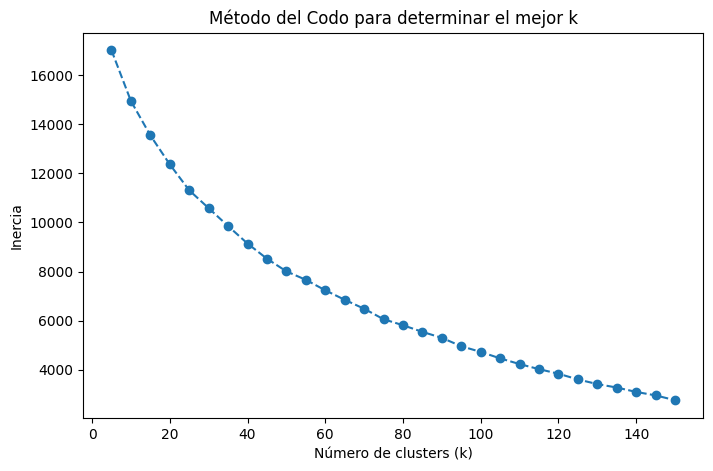

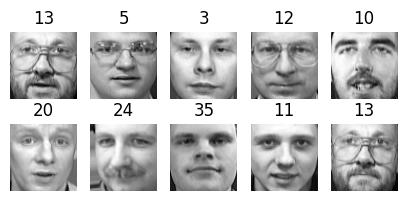

In [16]:


# Crear los pares X, y para train, validation y test
X_train, y_train = train_data.drop(columns=['target']), train_data['target']
X_valid, y_valid = val_data.drop(columns=['target']), val_data['target']  # Corregir nombre a X_valid
X_test, y_test = test_data.drop(columns=['target']), test_data['target']

# Mostrar el tamaño de cada conjunto
print(f"Tamaño del conjunto de entrenamiento: {len(X_train)}")
print(f"Tamaño del conjunto de validación: {len(X_valid)}")
print(f"Tamaño del conjunto de prueba: {len(X_test)}")

# Aplicar PCA para reducir la dimensionalidad con 99% de varianza explicada
pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

# Mostrar el número de componentes principales seleccionados
total_components = pca.n_components_
print(f"Número de componentes principales seleccionados: {total_components}")

# Encontrar el mejor número de clusters usando la métrica de silueta
best_k = 0
best_score = -1
for k in range(5, 151, 5):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_train_pca)
    silhouette_avg = silhouette_score(X_train_pca, cluster_labels)
    print(f"Para k={k}, el score de silueta es: {silhouette_avg}")
    
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_k = k

print(f"El mejor k es {best_k} con un score de silueta de {best_score}")

# Asignar el mejor modelo a la variable best_model
best_model = KMeans(n_clusters=best_k, random_state=42, n_init=10)
best_model.fit(X_train_pca)

# Método del codo para determinar el mejor K basándose en la inercia
inertia = []
k_values = list(range(5, 151, 5))
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train_pca)
    inertia.append(kmeans.inertia_)

# Graficar la inercia para el método del codo
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='--')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para determinar el mejor k')
plt.show()

# Función para visualizar algunas caras
def plot_faces(faces, labels, n_cols=5):
    faces = faces.values.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

# Visualizar algunas caras de entrenamiento
plot_faces(X_train.iloc[:10], y_train.iloc[:10])


### #1.9

Haz una valoración del método de clustering para el K elegido. Para ello crea un programa que recorra la lista de etiquetas dadas por "best_model" y que, haciendo uso de la función que ya te hemos proporcionado, pinte las caras asignadas a los 10 primeros clústeres. Ojo tendrás que hacer una pequeña adaptación porque las features de entrenamiento no son las features reales (son una "transformación" de estas) y si pasas el X de entrenamiento no verás nada. ¿Ves caras similares?

Tamaño del conjunto de entrenamiento: 320
Tamaño del conjunto de validación: 40
Tamaño del conjunto de prueba: 40
Número de componentes principales seleccionados: 221
Para k=5, el score de silueta es: 0.10690534114837646
Para k=10, el score de silueta es: 0.0917917937040329
Para k=15, el score de silueta es: 0.0968705415725708
Para k=20, el score de silueta es: 0.10888216644525528
Para k=25, el score de silueta es: 0.11888276040554047
Para k=30, el score de silueta es: 0.130244642496109
Para k=35, el score de silueta es: 0.1406320482492447
Para k=40, el score de silueta es: 0.1507929116487503
Para k=45, el score de silueta es: 0.1597384512424469
Para k=50, el score de silueta es: 0.17102989554405212
Para k=55, el score de silueta es: 0.16867895424365997
Para k=60, el score de silueta es: 0.1802489310503006
Para k=65, el score de silueta es: 0.1804104596376419
Para k=70, el score de silueta es: 0.18818716704845428
Para k=75, el score de silueta es: 0.19661825895309448
Para k=80, el scor

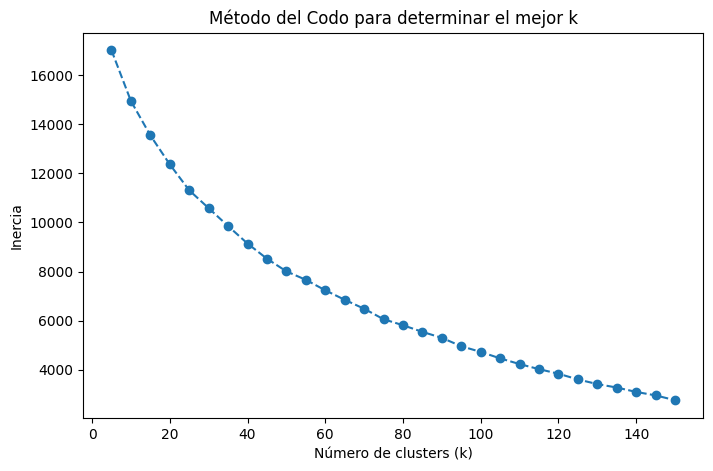

Mostrando imágenes del cluster 0


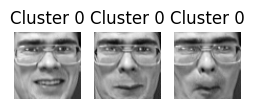

Mostrando imágenes del cluster 1


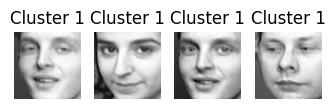

Mostrando imágenes del cluster 2


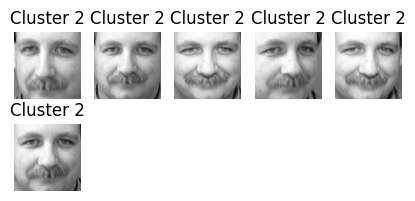

Mostrando imágenes del cluster 3


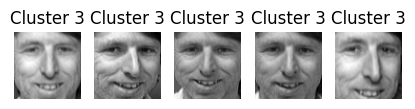

Mostrando imágenes del cluster 4


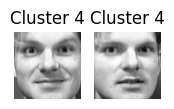

Mostrando imágenes del cluster 5


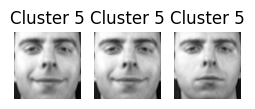

Mostrando imágenes del cluster 6


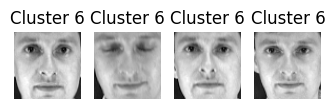

Mostrando imágenes del cluster 7


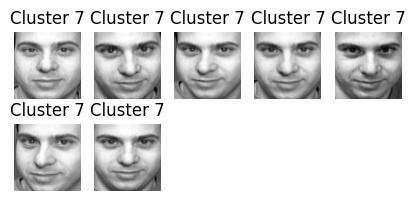

Mostrando imágenes del cluster 8


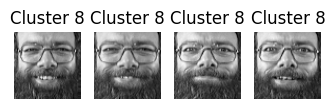

Mostrando imágenes del cluster 9


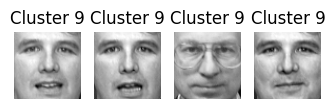

In [17]:


# Crear los pares X, y para train, validation y test
X_train, y_train = train_data.drop(columns=['target']), train_data['target']
X_valid, y_valid = val_data.drop(columns=['target']), val_data['target']  # Corregir nombre a X_valid
X_test, y_test = test_data.drop(columns=['target']), test_data['target']

# Mostrar el tamaño de cada conjunto
print(f"Tamaño del conjunto de entrenamiento: {len(X_train)}")
print(f"Tamaño del conjunto de validación: {len(X_valid)}")
print(f"Tamaño del conjunto de prueba: {len(X_test)}")

# Aplicar PCA para reducir la dimensionalidad con 99% de varianza explicada
pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

# Mostrar el número de componentes principales seleccionados
total_components = pca.n_components_
print(f"Número de componentes principales seleccionados: {total_components}")

# Encontrar el mejor número de clusters usando la métrica de silueta
best_k = 0
best_score = -1
for k in range(5, 151, 5):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_train_pca)
    silhouette_avg = silhouette_score(X_train_pca, cluster_labels)
    print(f"Para k={k}, el score de silueta es: {silhouette_avg}")
    
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_k = k

print(f"El mejor k es {best_k} con un score de silueta de {best_score}")

# Asignar el mejor modelo a la variable best_model
best_model = KMeans(n_clusters=best_k, random_state=42, n_init=10)
best_model.fit(X_train_pca)

# Método del codo para determinar el mejor K basándose en la inercia
inertia = []
k_values = list(range(5, 151, 5))
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train_pca)
    inertia.append(kmeans.inertia_)

# Graficar la inercia para el método del codo
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='--')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para determinar el mejor k')
plt.show()

# Función para visualizar algunas caras
def plot_faces(faces, labels, n_cols=5):
    faces = faces.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

# Obtener etiquetas de cluster asignadas por best_model
cluster_labels = best_model.labels_

# Mostrar caras de los 10 primeros clusters
for cluster in range(10):
    indices = np.where(cluster_labels == cluster)[0][:10]  # Obtener hasta 10 imágenes del cluster
    if len(indices) > 0:
        print(f"Mostrando imágenes del cluster {cluster}")
        plot_faces(X_train.iloc[indices].values, [f"Cluster {cluster}"] * len(indices))


## **#2**


### #2.1


Continuando con el conjunto de datos de caras Olivetti, entrena un clasificador para predecir qué persona está representada en cada imagen, y evalúalo en el conjunto de validación. Utiliza un RandomForest con 150 submodelos o estimadores (y el resto de hiperparámetros déjalos a su valor por defecto)

In [19]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_score, accuracy_score


# Crear los pares X, y para train, validation y test
X_train, y_train = train_data.drop(columns=['target']), train_data['target']
X_valid, y_valid = val_data.drop(columns=['target']), val_data['target']  # Corregir nombre a X_valid
X_test, y_test = test_data.drop(columns=['target']), test_data['target']

# Mostrar el tamaño de cada conjunto
print(f"Tamaño del conjunto de entrenamiento: {len(X_train)}")
print(f"Tamaño del conjunto de validación: {len(X_valid)}")
print(f"Tamaño del conjunto de prueba: {len(X_test)}")

# Aplicar PCA para reducir la dimensionalidad con 99% de varianza explicada
pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

# Mostrar el número de componentes principales seleccionados
total_components = pca.n_components_
print(f"Número de componentes principales seleccionados: {total_components}")

# Entrenar un RandomForestClassifier con 150 estimadores
rf_model = RandomForestClassifier(n_estimators=150, random_state=42)
rf_model.fit(X_train_pca, y_train)

# Evaluar el modelo en el conjunto de validación
y_valid_pred = rf_model.predict(X_valid_pca)
accuracy = accuracy_score(y_valid, y_valid_pred)
print(f"Precisión del modelo RandomForest en el conjunto de validación: {accuracy:.4f}")


Tamaño del conjunto de entrenamiento: 320
Tamaño del conjunto de validación: 40
Tamaño del conjunto de prueba: 40
Número de componentes principales seleccionados: 221
Precisión del modelo RandomForest en el conjunto de validación: 0.9250


### #2.2

Utiliza K-Means como una herramienta de reducción de dimensionalidad y entrena un clasificador en el conjunto reducido. Para ello emplea el método transform de manera que ahora las features de entrada sean las distancias de cada punto a los centroides del modelo "best_model" de la parte anterior. Por ejemplo:
```python
X_train_reduced = best_model.transform(X_train_pca) 
```


Ojo lo tienes que aplicar a todos los datasets. Luego vuelve a entrenar un RandomForest sobre este dataset y evalualo contra el dataset de validacion.

In [20]:

from sklearn.ensemble import RandomForestClassifier


# Crear los pares X, y para train, validation y test
X_train, y_train = train_data.drop(columns=['target']), train_data['target']
X_valid, y_valid = val_data.drop(columns=['target']), val_data['target']  # Corregir nombre a X_valid
X_test, y_test = test_data.drop(columns=['target']), test_data['target']

# Mostrar el tamaño de cada conjunto
print(f"Tamaño del conjunto de entrenamiento: {len(X_train)}")
print(f"Tamaño del conjunto de validación: {len(X_valid)}")
print(f"Tamaño del conjunto de prueba: {len(X_test)}")

# Aplicar PCA para reducir la dimensionalidad con 99% de varianza explicada
pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

# Mostrar el número de componentes principales seleccionados
total_components = pca.n_components_
print(f"Número de componentes principales seleccionados: {total_components}")

# Aplicar K-Means para reducción de dimensionalidad en todos los datasets
best_model.fit(X_train_pca)  # Asegurar que el modelo K-Means se entrena con el conjunto de entrenamiento
X_train_reduced = best_model.transform(X_train_pca)
X_valid_reduced = best_model.transform(X_valid_pca)
X_test_reduced = best_model.transform(X_test_pca)

# Entrenar un RandomForestClassifier con 150 estimadores en el conjunto reducido
rf_model_reduced = RandomForestClassifier(n_estimators=150, random_state=42)
rf_model_reduced.fit(X_train_reduced, y_train)

# Evaluar el modelo en el conjunto de validación reducido
y_valid_pred_reduced = rf_model_reduced.predict(X_valid_reduced)
accuracy_reduced = accuracy_score(y_valid, y_valid_pred_reduced)
print(f"Precisión del modelo RandomForest en el conjunto reducido: {accuracy_reduced:.4f}")


Tamaño del conjunto de entrenamiento: 320
Tamaño del conjunto de validación: 40
Tamaño del conjunto de prueba: 40
Número de componentes principales seleccionados: 221
Precisión del modelo RandomForest en el conjunto reducido: 0.8250


### #2.3 EXTRA VOLUNTARIO

Busca el número de clusters k que generen un algoritmo kmeans que a su vez sus distancias a los centroides sean las features de un clasificador RandomForest y que permita al clasificador obtener el mejor rendimiento: ¿Qué rendimiento puedes alcanzar? (en terminos de Accuracy)

In [21]:


# Crear los pares X, y para train, validation y test
X_train, y_train = train_data.drop(columns=['target']), train_data['target']
X_valid, y_valid = val_data.drop(columns=['target']), val_data['target']  # Corregir nombre a X_valid
X_test, y_test = test_data.drop(columns=['target']), test_data['target']

# Mostrar el tamaño de cada conjunto
print(f"Tamaño del conjunto de entrenamiento: {len(X_train)}")
print(f"Tamaño del conjunto de validación: {len(X_valid)}")
print(f"Tamaño del conjunto de prueba: {len(X_test)}")

# Aplicar PCA para reducir la dimensionalidad con 99% de varianza explicada
pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

# Mostrar el número de componentes principales seleccionados
total_components = pca.n_components_
print(f"Número de componentes principales seleccionados: {total_components}")

# Encontrar el mejor número de clusters para K-Means con base en la precisión del clasificador
best_k = None
best_accuracy = 0
k_values = range(5, 151, 5)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train_pca)
    
    X_train_reduced = kmeans.transform(X_train_pca)
    X_valid_reduced = kmeans.transform(X_valid_pca)
    X_test_reduced = kmeans.transform(X_test_pca)
    
    rf_model = RandomForestClassifier(n_estimators=150, random_state=42)
    rf_model.fit(X_train_reduced, y_train)
    
    y_valid_pred = rf_model.predict(X_valid_reduced)
    accuracy = accuracy_score(y_valid, y_valid_pred)
    print(f"Para k={k}, la precisión es: {accuracy:.4f}")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k

print(f"El mejor k es {best_k} con una precisión de {best_accuracy:.4f}")


Tamaño del conjunto de entrenamiento: 320
Tamaño del conjunto de validación: 40
Tamaño del conjunto de prueba: 40
Número de componentes principales seleccionados: 221
Para k=5, la precisión es: 0.3750
Para k=10, la precisión es: 0.5750
Para k=15, la precisión es: 0.6750
Para k=20, la precisión es: 0.6750
Para k=25, la precisión es: 0.7000
Para k=30, la precisión es: 0.7000
Para k=35, la precisión es: 0.7750
Para k=40, la precisión es: 0.8250
Para k=45, la precisión es: 0.8000
Para k=50, la precisión es: 0.8000
Para k=55, la precisión es: 0.7500
Para k=60, la precisión es: 0.7500
Para k=65, la precisión es: 0.8000
Para k=70, la precisión es: 0.7500
Para k=75, la precisión es: 0.8000
Para k=80, la precisión es: 0.7750
Para k=85, la precisión es: 0.8000
Para k=90, la precisión es: 0.8000
Para k=95, la precisión es: 0.8000
Para k=100, la precisión es: 0.7500
Para k=105, la precisión es: 0.7500
Para k=110, la precisión es: 0.7750
Para k=115, la precisión es: 0.7750
Para k=120, la precisión 